## Import Required Libraries

In [181]:
import pandas as pd
import numpy as np
import geopandas as gpd
import matplotlib.pyplot as plt
import pyproj
import contextily as ctx
import seaborn as sns
import geoplot as gplt
import geoplot.crs as gcrs
import folium
import matplotlib.ticker as ticker
import scipy.stats
import webbrowser
from scipy.stats import shapiro
import statsmodels.api as sm
from scipy.stats import spearmanr
from scipy.stats import kendalltau
from sklearn.preprocessing import MinMaxScaler
import matplotlib
from IPython.display import display, HTML, Image
import json
from scipy import stats
%matplotlib inline
import dataframe_image as dfi
import mgwr
import libpysal as ps
from mgwr.gwr import GWR, MGWR
from mgwr.sel_bw import Sel_BW
from mgwr.utils import compare_surfaces, truncate_colormap
from matplotlib.colors import LinearSegmentedColormap
from shapely.geometry import Point
import pysal
from pysal.model import spreg
import textwrap
import matplotlib.colors as colors
import statsmodels.api as sm
import matplotlib.pyplot as plt
from esda.moran import Moran
from splot.esda import moran_scatterplot, plot_moran
from esda.smaup import Smaup
from pysal.explore import esda
from libpysal.weights import Queen
from statsmodels.stats.outliers_influence import variance_inflation_factor

## Prepare the Datasets

In [182]:
#  read in the Re-ordered Oxfordshire PPFI (V2) Data 
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/Datasets/PPFI V2 Ox Reordered.xlsx"
ppfi_Ox_Reordered = pd.read_excel(file_path)

# read in the Geographic Lookup Table (full lookup)
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/Datasets/Full Lookup.xlsx"
full_lookup = pd.read_excel(file_path)

# read in the Oxfordshire Ward-Level Child Obesity Y6 data
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/Datasets/Cleaned - Oxfordshire Ward Level Data.xlsx"
Ox_ObesityY6 = pd.read_excel(file_path, sheet_name="Obesity_Year6")

# read in the JSON data to get the coordinates
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/Datasets/LSOAs_SHP.json"
Ox_JSON = gpd.read_file(file_path)

# read in the Oxon Demographics Data (Household count, Population Density, RUC)
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/Datasets/Oxon Demographics (RUC, Household, Pop Density).xlsx"
Ox_dem = pd.read_excel(file_path)

# read in the MSOA 2021 Names and codes (for concatenating the LSOA number with the MSOA Name)
file_path = "C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/Datasets/MSOA Names 2021.xlsx"
MSOA_2021 = pd.read_excel(file_path)

### Merge the health data with the lookup table

In [183]:
Ox_ObesityY6 = Ox_ObesityY6.merge(full_lookup[[
    'LSOA21CD','LSOA21NM','MSOA21CD','WD16CD'
]], on='WD16CD',how='inner')

### Drop the unneccessary column from the PPFI data

In [184]:
ppfi_Ox_Reordered = ppfi_Ox_Reordered.drop(['Unnamed: 0','LSOA11NM','LSOA11CD'],axis=1)

### Merge with the PPFI data

In [185]:
ppfi_Ox_Reordered = ppfi_Ox_Reordered.merge(Ox_ObesityY6[[
    '% Obese Children (Year 6)','LSOA21CD','MSOA21CD']], on='LSOA21CD', how='inner')

### Drop the duplicate rows

In [186]:
ppfi_Ox_Reordered = ppfi_Ox_Reordered.drop_duplicates()

### Remove the unwanted columns from the JSON data

In [187]:
Ox_JSON = Ox_JSON.drop(['BNG_E', 'BNG_N', 'LONG', 'LAT', 'GlobalID'],axis=1)

### Merge the PPFI and JSON Data

In [188]:
ppfi_Ox_Reordered = ppfi_Ox_Reordered.merge(Ox_JSON[['LSOA21CD','geometry']], on='LSOA21CD', how='inner')

### Merge with the MSOA 2021 Data

In [189]:
ppfi_Ox_Reordered = ppfi_Ox_Reordered.merge(MSOA_2021, on='MSOA21CD',how='inner')

### Create the column concatenating the MSOA name with the LSOA area number

In [190]:
ppfi_Ox_Reordered['Area'] = ppfi_Ox_Reordered['MSOA21NM'] + " " + ppfi_Ox_Reordered['LSOA21NM'].str.slice(start=-4)

### Convert the merged dataframe to a GeoPandas one

In [191]:
ppfi_Ox_Reordered = gpd.GeoDataFrame(ppfi_Ox_Reordered, geometry='geometry')

### Convert the geometry column to centroids in order to fit the GWR model

In [192]:
points = ppfi_Ox_Reordered.centroid

C:\Users\medaamm\AppData\Local\Temp\ipykernel_16944\4215279618.py:1: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  points = ppfi_Ox_Reordered.centroid


## Fit an OLS regression model for Child Obesity at Year Six as DV and PPFI dimensions as IVs

### Correct the data types of all columns to numeric

In [193]:
cols = ['Supermarket Proximity', 'Supermarket Accessibility','Non-Supermarket Proximity',
        'Fuel Poverty','Socio-demographic Barriers','Food Support for Families',
        'E-Commerce Access']
ppfi_Ox_Reordered[cols] = ppfi_Ox_Reordered[cols].apply(pd.to_numeric)

### Define the dependent and independent variables

In [194]:
# define the dependent variable as the prevalence of child obesity at Y6
y = ppfi_Ox_Reordered['% Obese Children (Year 6)'].values.reshape(-1,1)

# define the independent variables as the dimensions of the PPFI
X = ppfi_Ox_Reordered[cols].values

### Fit the Model

In [195]:
X = sm.add_constant(X)
OLS_model = sm.OLS(y,X).fit()

### Assess Spatial Autocorrelation in the Residuals

C:\Users\medaamm\AppData\Local\Temp\ipykernel_16944\2341948251.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = ps.weights.Queen.from_dataframe(ppfi_Ox_Reordered)
C:\Users\medaamm\AppData\Local\anaconda3\Lib\site-packages\splot\_viz_esda_mpl.py:354: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sbn.kdeplot(moran.sim, shade=shade, color=color, ax=ax, **kwargs)


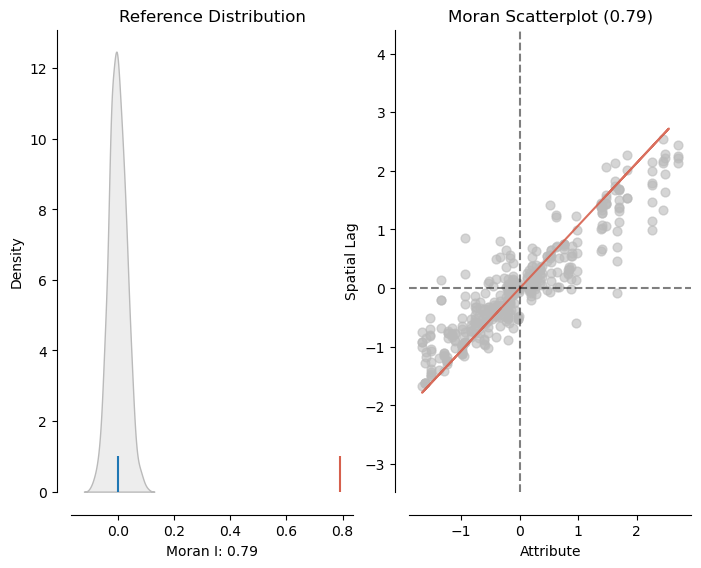

In [196]:
w = ps.weights.Queen.from_dataframe(ppfi_Ox_Reordered)
moran = Moran(ppfi_Ox_Reordered['% Obese Children (Year 6)'], w)
plot_moran(moran, zstandard=True,figsize=(8,6))
plt.show()

### Assess multicollinearity

In [197]:
# Get the exogenous variables
variables = OLS_model.model.exog

# calculate the VIF for each variable
vif = [variance_inflation_factor(variables, i) for i in range(variables.shape[1])]

#### Fit a model for Child obesity at Year 6 as DV and PPFI with dimensions as IVs

### Correct the data types of all columns to numeric

In [199]:
cols = ['Supermarket Proximity', 'Supermarket Accessibility','Non-Supermarket Proximity',
        'Fuel Poverty','Socio-demographic Barriers','Food Support for Families',
        'E-Commerce Access']
ppfi_Ox_Reordered[cols] = ppfi_Ox_Reordered[cols].apply(pd.to_numeric)

### Define the dependent and independent variables

In [200]:
# define the dependent variable as Y6 obesity levels
y = ppfi_Ox_Reordered['% Obese Children (Year 6)'].values.reshape(-1,1)

# define the independent variables as the dimensions of the PPFI
X = ppfi_Ox_Reordered[cols].values

### Define the point coordinates of the LSOA centroids

In [201]:
u = points.x
v = points.y
coords = list(zip(u,v))

### Calibrate the model to select the optimal bandwidth

In [202]:
gwr_selector = Sel_BW(coords, y, X, kernel='bisquare')
gwr_bw = gwr_selector.search()
print(gwr_bw)

60.0


### Fit the model

In [203]:
gwr_model = GWR(coords,y,X,kernel='bisquare', bw=gwr_bw)

### Get the model results

In [204]:
gwr_results = gwr_model.fit()

### Get the global R-squared value

In [205]:
global_R2 = gwr_results.R2
print(global_R2)

0.8636482659703164


### Plot the local R2 at the LSOA Level (Static Map)

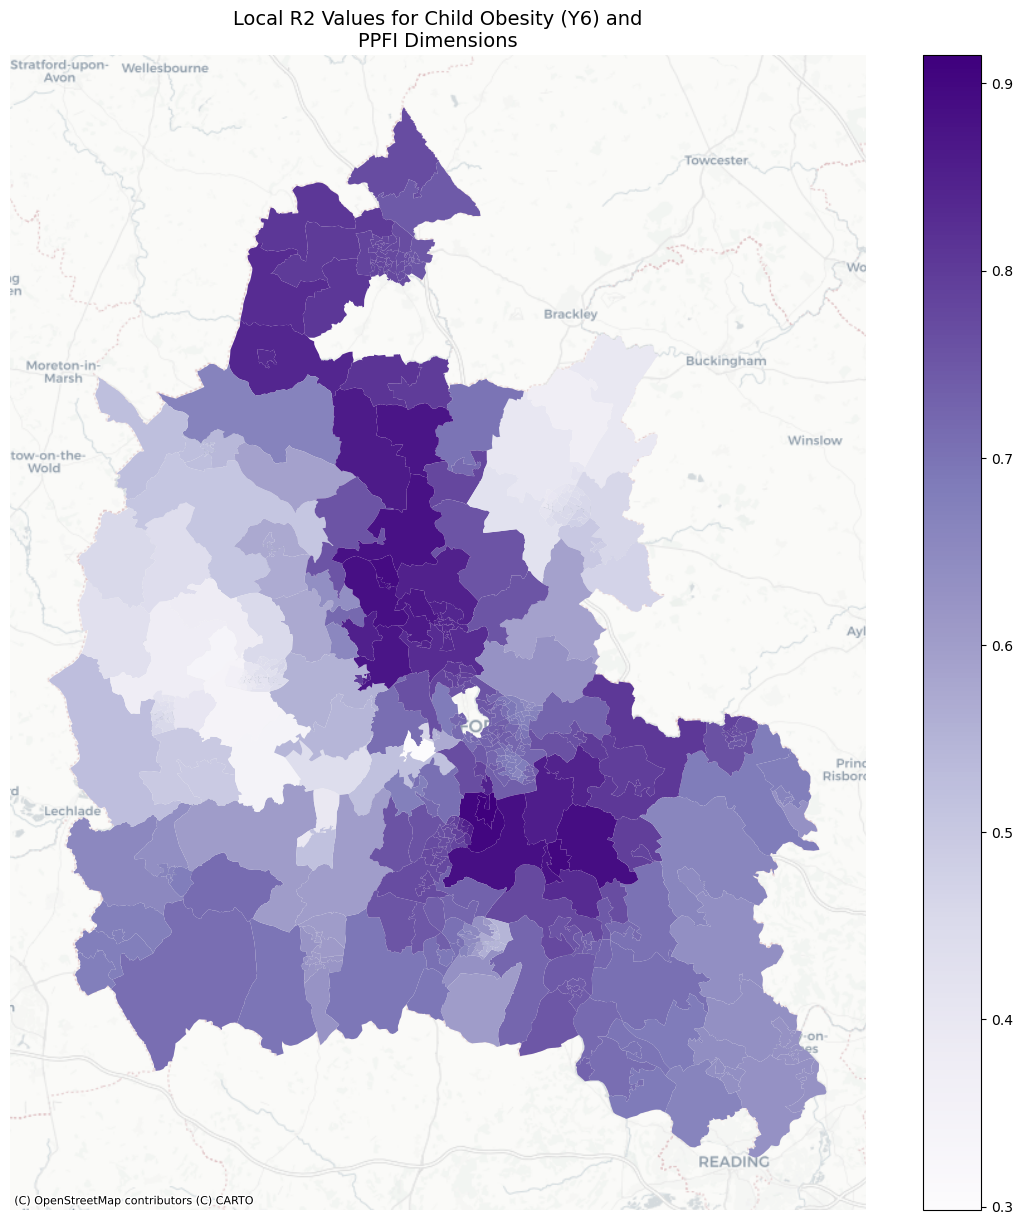

In [206]:
# plot the R2 values
ppfi_Ox_Reordered['R2'] = gwr_results.localR2

# define custom color map for R2
vmin = ppfi_Ox_Reordered['R2'].min()
vmax = ppfi_Ox_Reordered['R2'].max()
norm = matplotlib.colors.TwoSlopeNorm(vmin=vmin, vcenter = (vmin+vmax)/2, vmax=vmax)

fig,ax = plt.subplots(figsize=(15,15))
ppfi_Ox_Reordered.to_crs('EPSG:3857').plot(ax=ax, column='R2', legend=True, cmap='Purples', norm=norm)
plt.axis('off')
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)
title = 'Local R2 Values for Child Obesity (Y6) and PPFI Dimensions'
wrapped_title = '\n'.join(textwrap.wrap(title,45))
plt.title(wrapped_title, fontsize=14)
plt.show()

### Explore the coefficient estimates by creating a dataframe containing all the values

In [207]:
# Create a table for the Model coefficients and intercept values
model_parameters_ObesityY6 = pd.DataFrame(gwr_results.params, 
                               columns = ['Intercept','Supermarket Proximity', 
                                          'Supermarket Accessibility','Non-Supermarket Proximity',
                                          'Fuel Poverty','Socio-demographic Barriers',
                                          'Food Support for Families',
                                          'E-Commerce Access']
                               )

# add the geometry and LSOA columns to the model parameters dataframe
model_parameters_ObesityY6 = model_parameters_ObesityY6.assign(LSOA21CD = ppfi_Ox_Reordered['LSOA21CD'])
model_parameters_ObesityY6 = model_parameters_ObesityY6.assign(LSOA21NM = ppfi_Ox_Reordered['LSOA21NM'])
model_parameters_ObesityY6 = model_parameters_ObesityY6.assign(Area = ppfi_Ox_Reordered['Area'])
model_parameters_ObesityY6 = model_parameters_ObesityY6.assign(geometry = ppfi_Ox_Reordered['geometry'])
model_parameters_ObesityY6 = model_parameters_ObesityY6.assign(localR2 = ppfi_Ox_Reordered['R2'])
model_parameters_ObesityY6 = model_parameters_ObesityY6.assign(District = ppfi_Ox_Reordered['District'])

### Create a summary of the model parameters for each of the five districts

In [208]:
Districts_modelParams = model_parameters_ObesityY6[['Intercept', 'Supermarket Proximity', 'Supermarket Accessibility',
       'Non-Supermarket Proximity', 'Fuel Poverty',
       'Socio-demographic Barriers', 'Food Support for Families',
       'E-Commerce Access','District']].groupby('District').agg(['mean','median']).round(3)
Districts_modelParams.to_excel("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/Datasets/GWR with Child Obesity (Year Six).xlsx", sheet_name="Model 2 District-Level Summary")

### Convert the created dataframe to a GeoPandas one for creating maps

In [209]:
model_parameters_ObesityY6 = gpd.GeoDataFrame(model_parameters_ObesityY6, geometry='geometry')

### Generate maps of the estimated coefficients

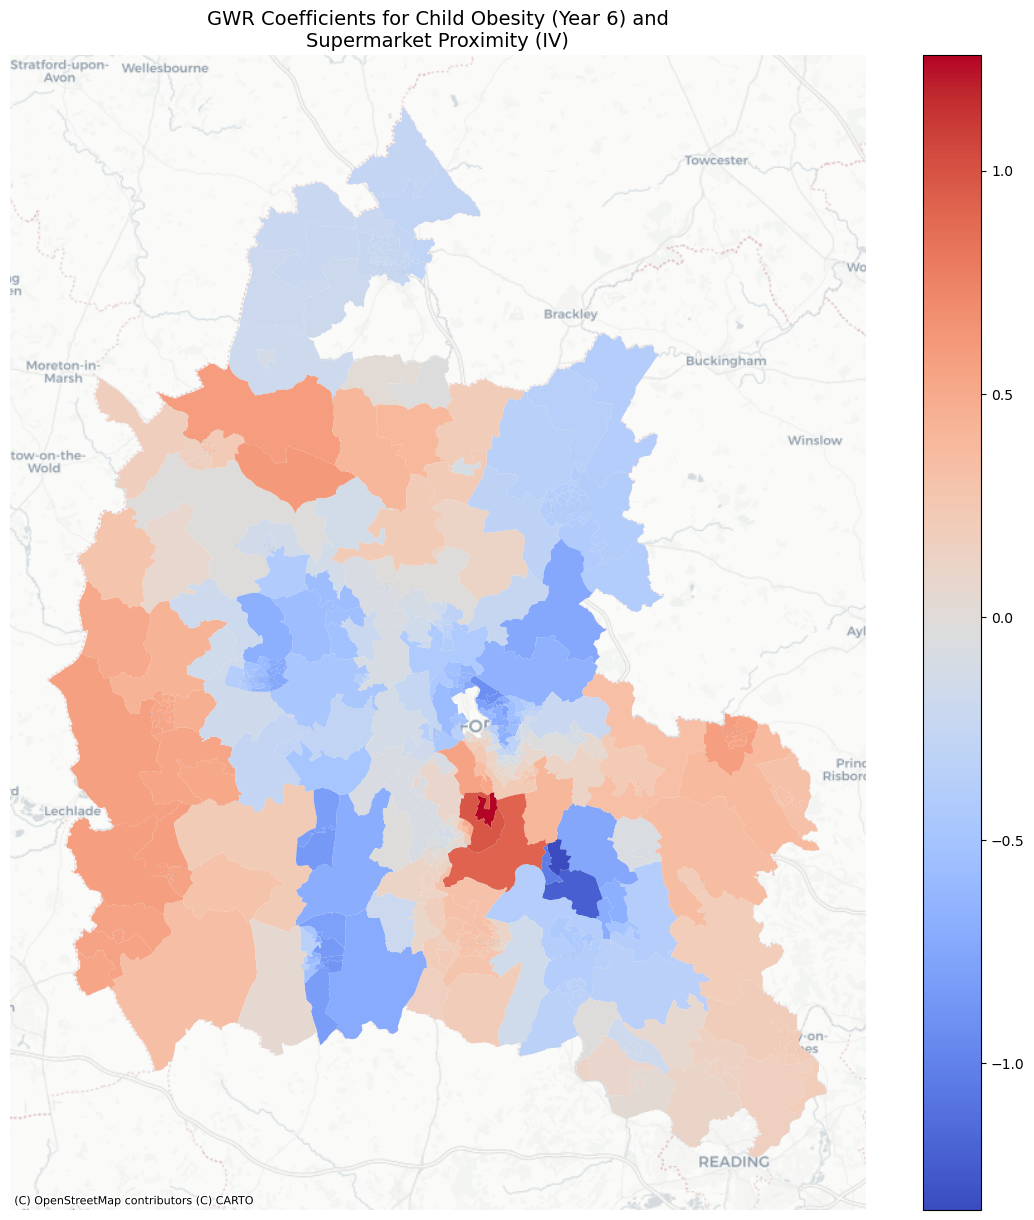

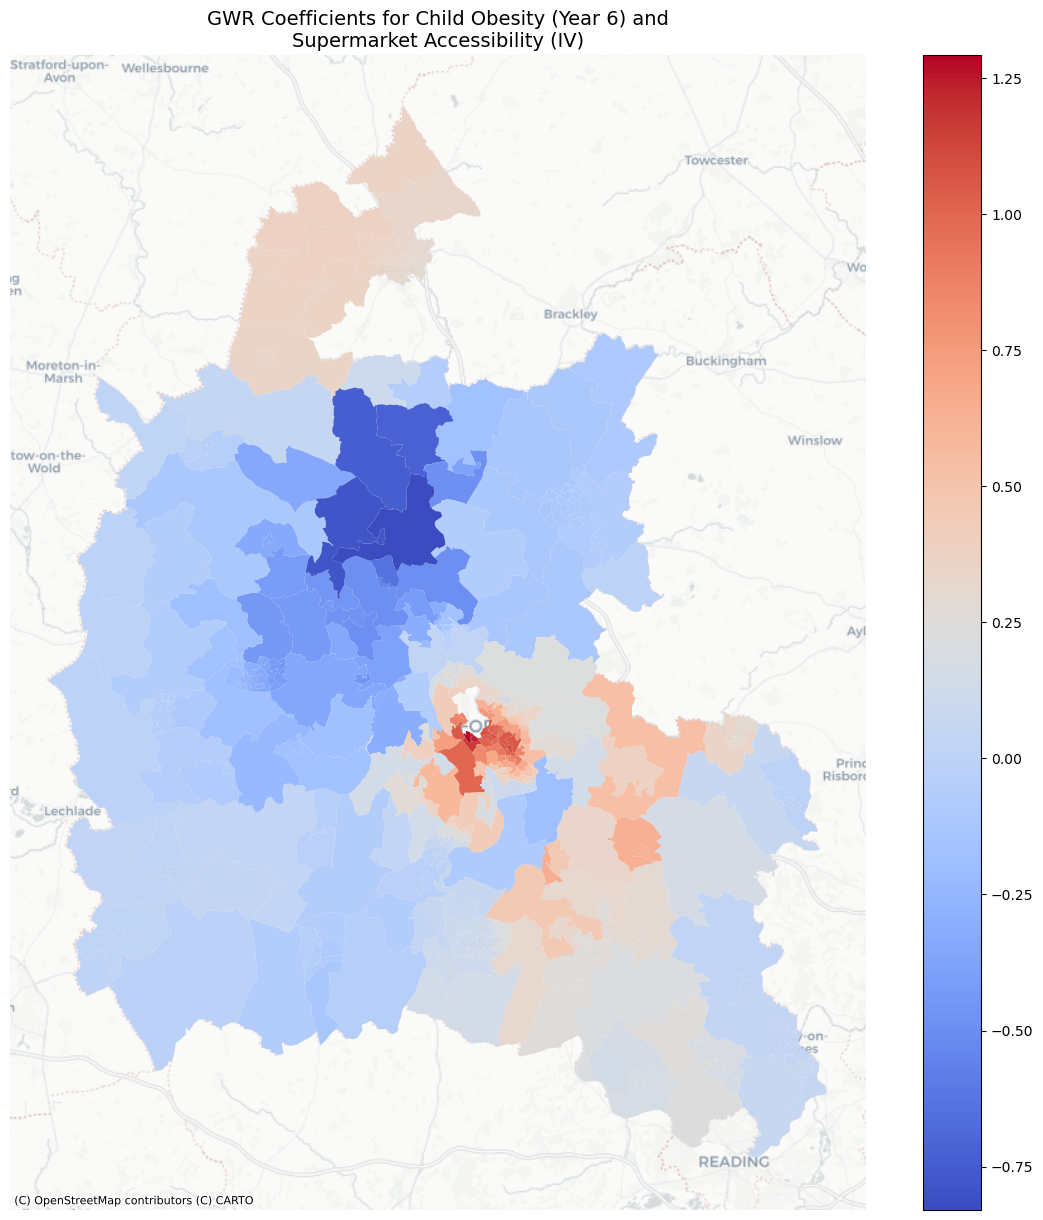

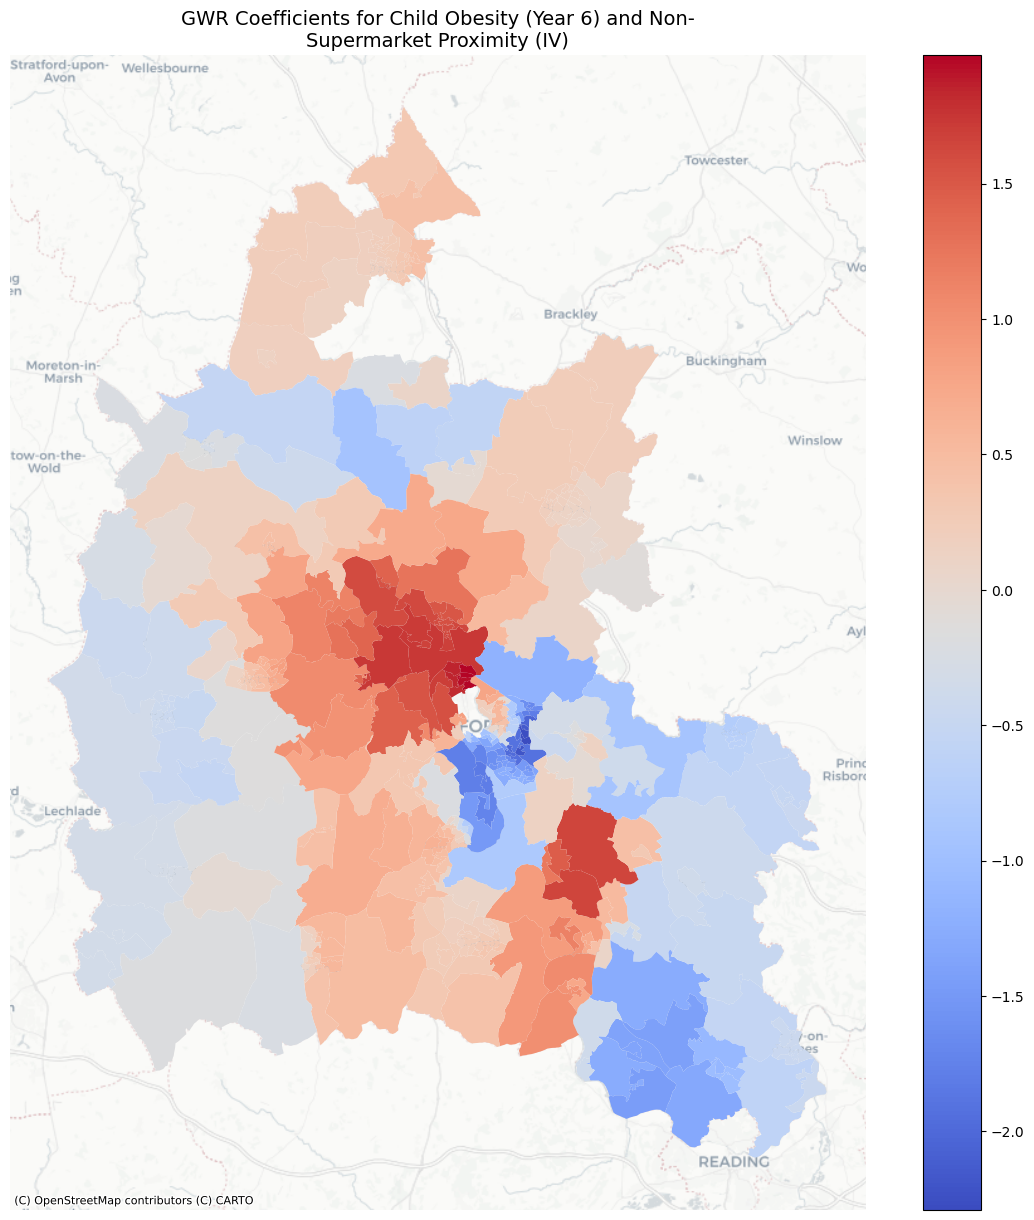

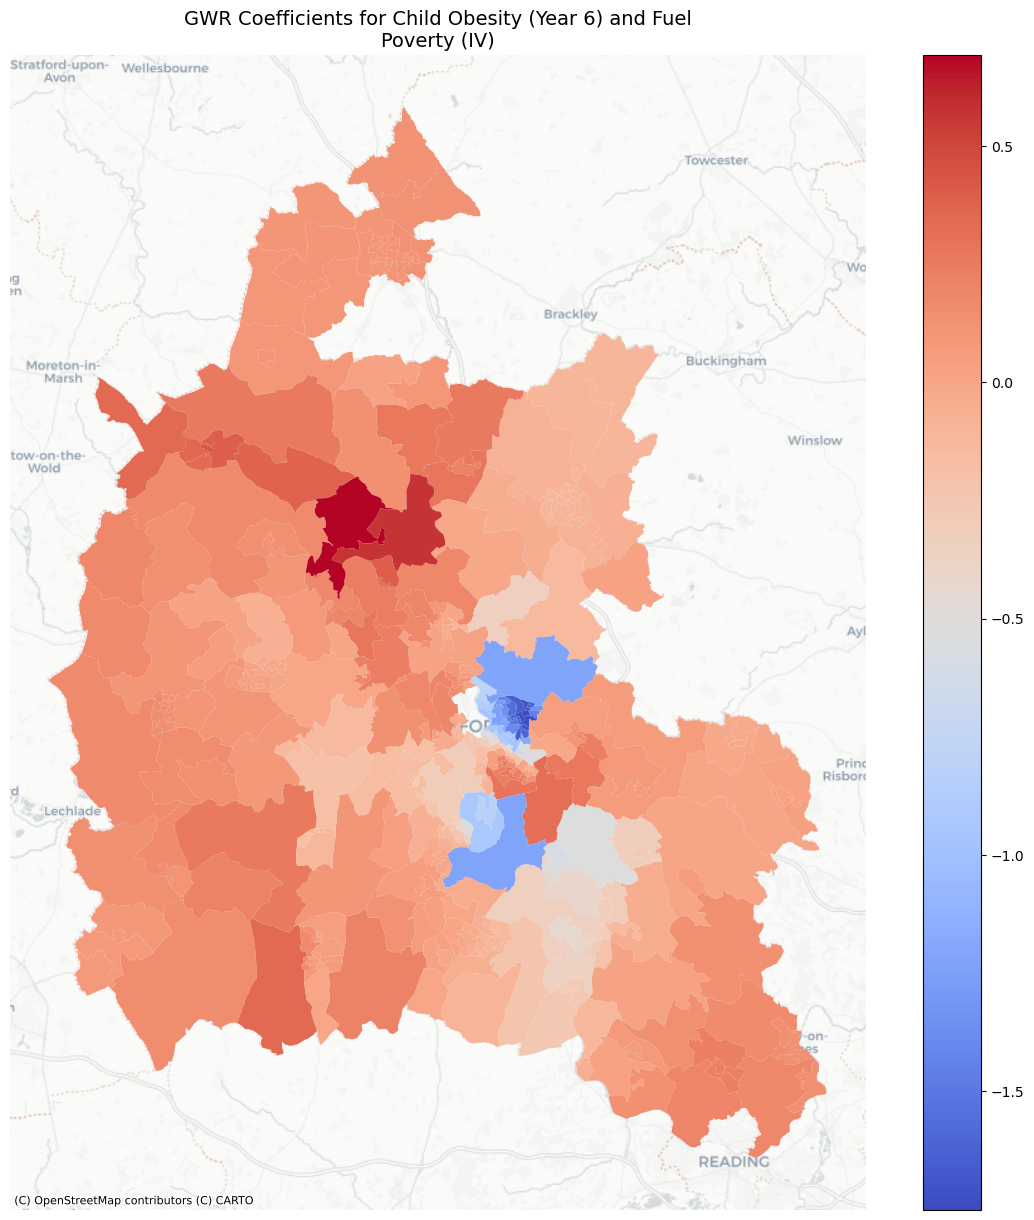

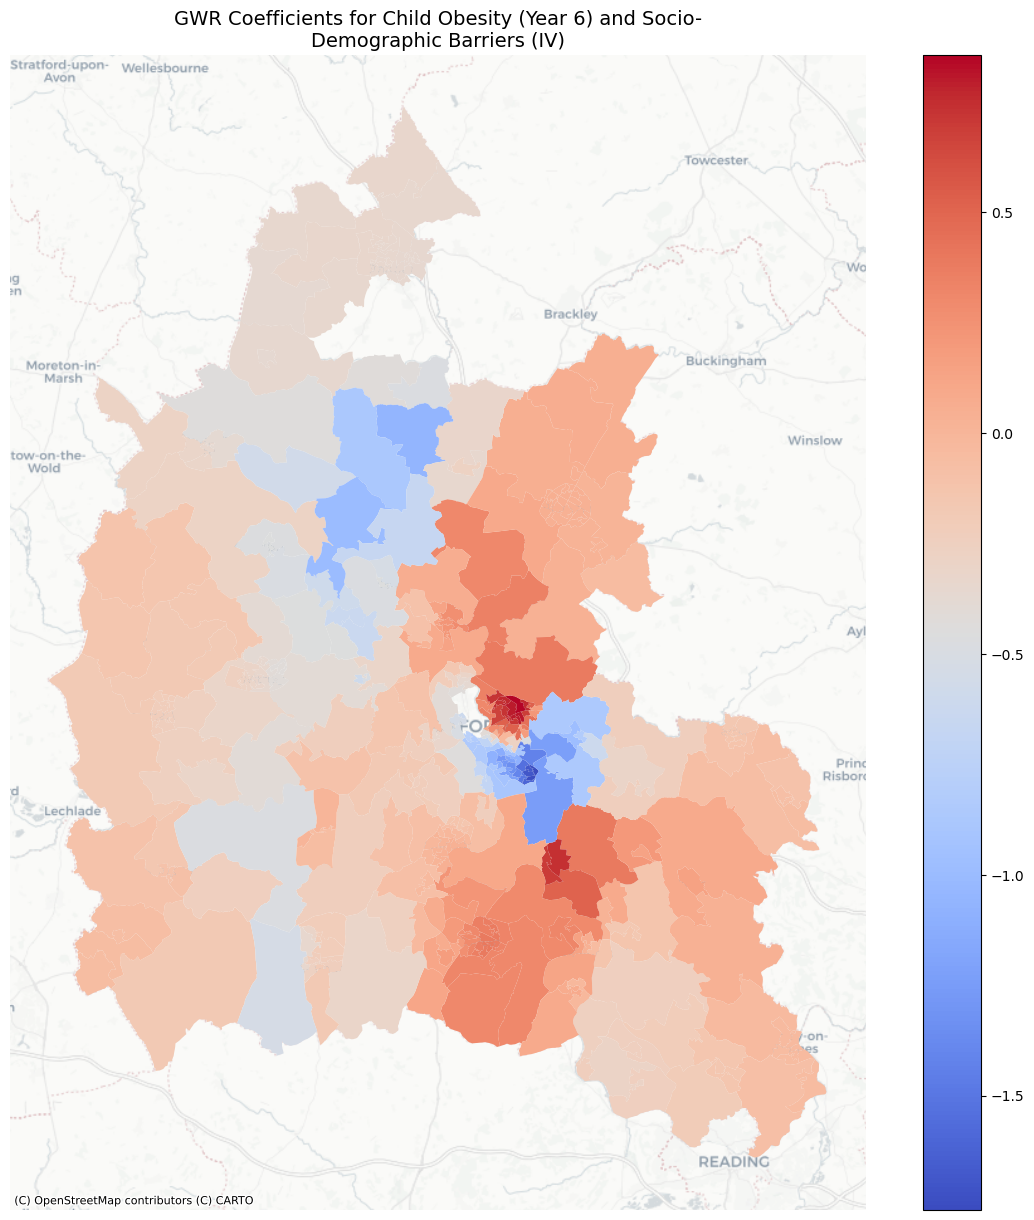

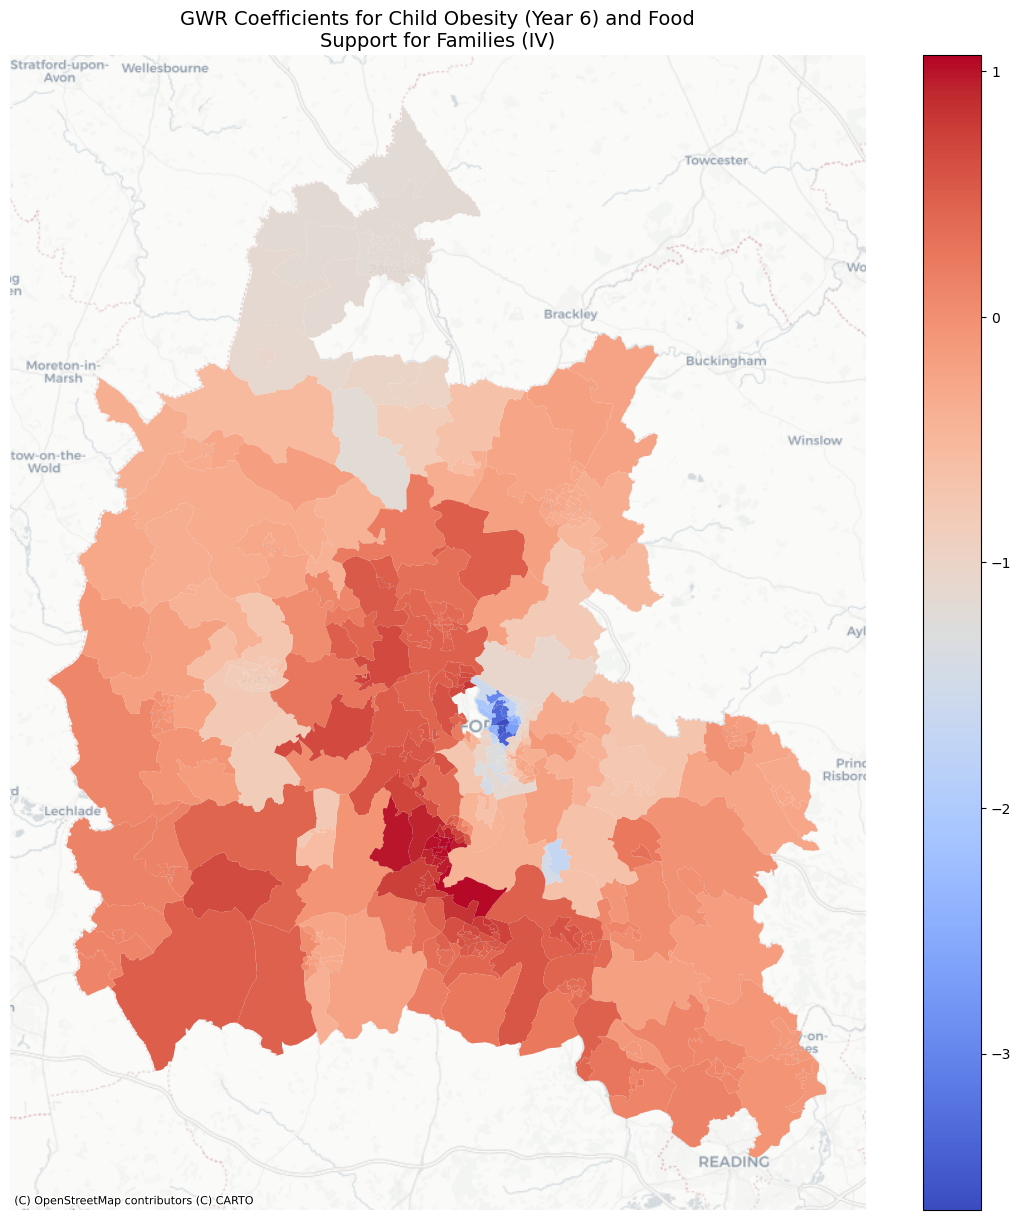

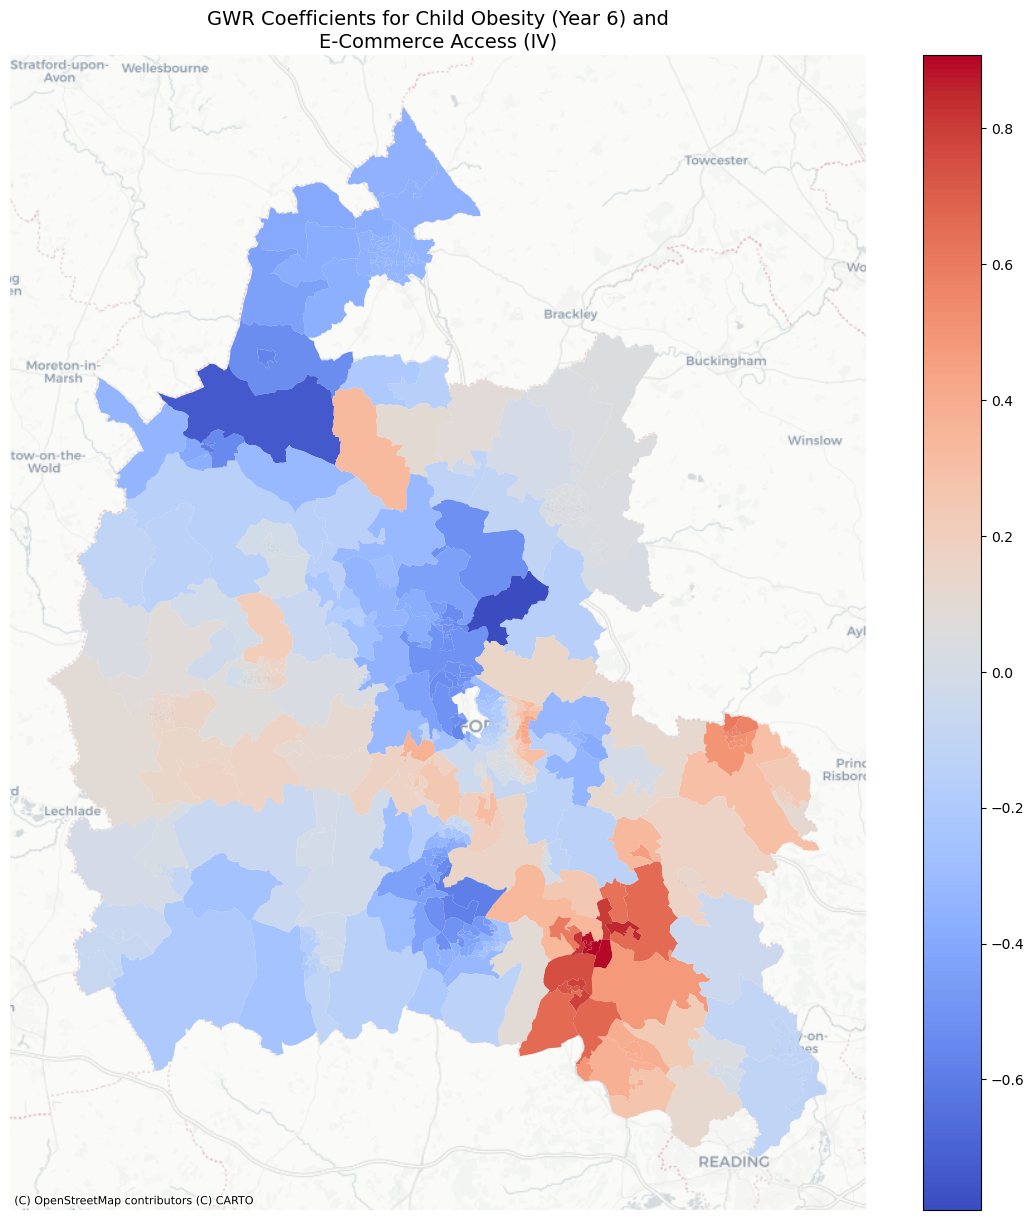

In [210]:
cols = ['Supermarket Proximity','Supermarket Accessibility','Non-Supermarket Proximity',
        'Fuel Poverty','Socio-demographic Barriers','Food Support for Families',
       'E-Commerce Access']
titles = ['Supermarket Proximity', 'Supermarket Accessibility', 'Non-Supermarket Proximity', 'Fuel Poverty',
         'Socio-Demographic Barriers','Food Support for Families', 'E-Commerce Access']

for i,col,title in zip(range(len(cols)),cols,titles):
    fig,ax = plt.subplots(figsize=(15,15))
    
    # define custom color map for the coefficients
    vmin = model_parameters_ObesityY6[col].min()
    vmax = model_parameters_ObesityY6[col].max()
    norm = matplotlib.colors.TwoSlopeNorm(vmin=vmin, vcenter = (vmin+vmax)/2, vmax=vmax)
    
    model_parameters_ObesityY6.to_crs('EPSG:3857').plot(ax=ax, column=col, legend=True, cmap='coolwarm',
                                                        norm=norm)
    title = f"GWR Coefficients for Child Obesity (Year 6) and {title} (IV)"
    wrapped_title = '\n'.join(textwrap.wrap(title,55))
    plt.title(wrapped_title, fontsize=14)
    ax.set_axis_off()
    ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)
    plt.show()

### Define a color map for the significant coefficient estimates

In [211]:
# define a color map with white at zero
vmin = -4
vmax = 2
norm = matplotlib.colors.TwoSlopeNorm(vmin=vmin, vcenter=0, vmax=vmax)
cmap="RdBu_r"

## Explore Model Diagnostics

### Check the summary of the model results

In [212]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 409
Number of covariates:                                                     8

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           4602.786
Log-likelihood:                                                   -1075.379
AIC:                                                               2166.759
AICc:                                                              2169.210
BIC:                                                               2191.287
R2:                                                                   0.435
Adj. R2:                                                              0.425

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### Generate a statistical summary of the model parameters

In [213]:
parameters_summary = pd.DataFrame()
col_names = ['Intercept', 'Supermarket Proximity','Supermarket Accessibility','Non-Supermarket Proximity',
            'Fuel Poverty','Socio-Demographic Barriers','Family Food Support','E-Commerce Access']
lst = ['Mean','STD','Min','Median','Max']
parameters_summary['Variable'] = col_names

mean_values = []
sd_values = []
min_values = []
median_values = []
max_values = []

gwr_results_df = pd.DataFrame(gwr_results.params)

for i in range(8):
    mean = gwr_results_df[i].mean()
    mean_values.append(round(mean,3))
    
    std = gwr_results_df[i].std()
    sd_values.append(round(std,3))
    
    minimum = gwr_results_df[i].min()
    min_values.append(round(minimum,3))
    
    maximum = gwr_results_df[i].max()
    max_values.append(round(maximum,3))
    
    median = gwr_results_df[i].median()
    median_values.append(round(median,3))

parameters_summary['Mean'] = mean_values
parameters_summary['STD'] = sd_values
parameters_summary['Min'] = min_values
parameters_summary['Median'] = median_values
parameters_summary['Max'] = max_values

### Export the Parameters Summary to an Excel file

In [214]:
with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/Datasets/GWR with Child Obesity (Year Six).xlsx",
                   engine="openpyxl", mode="a") as writer:
    parameters_summary.to_excel(writer, sheet_name = "Model 2 Parameters Summary")


### Define a formatting style for the plots to come

In [215]:
kwargs = {'edgecolor':'black',
         'linewidth':0.5
         }

### Visualizing the Statistical Significance of the Parameter Estimates

In [216]:
# default behaviour using corrected alpha
filter_tc = gwr_results.filter_tvals()

# without correction using common alpha
filter_t = gwr_results.filter_tvals(alpha=0.05)

# create a dataframe for the parameter estimates
parameter_estimates = pd.DataFrame()

# column names used to loop through and capture the model estimates
columns_significance = ['Supermarket Proximity','Supermarket Accessibility','Non-Supermarket Proximity',
                        'Fuel Poverty','Socio-demographic Barriers',
                        'Food Support for Families','E-Commerce Access']

# loop through to capture the parameter estimates
for col,i in list(zip(columns_significance, range(1,8))):
    parameter_estimates[col] = gwr_results.params[:,i]
    parameter_estimates[col+"_t"] = filter_t[:,i]
    parameter_estimates[col+"_tc"] = filter_tc[:,i]

# add other useful columns 
parameter_estimates[['LSOA21CD','LSOA21NM','Area','geometry','District']] = ppfi_Ox_Reordered[['LSOA21CD','LSOA21NM','Area','geometry','District']]

# convert the merged dataframe to a GeoPandas one
parameter_estimates = gpd.GeoDataFrame(parameter_estimates, geometry='geometry').to_crs('EPSG:3857')

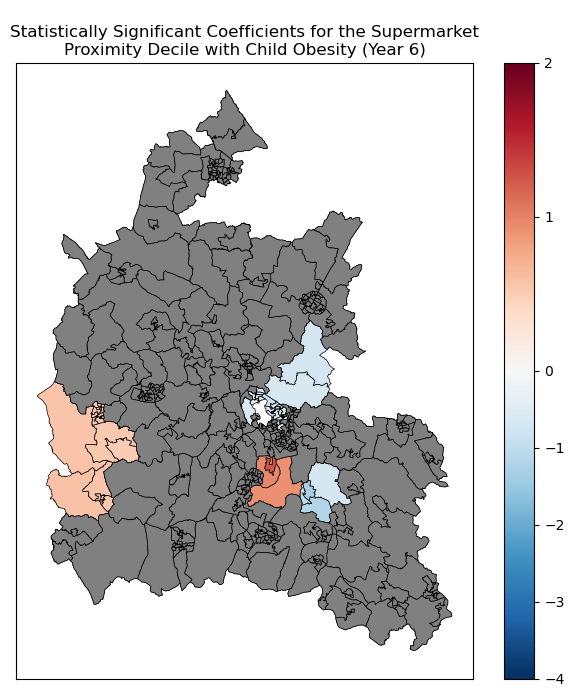

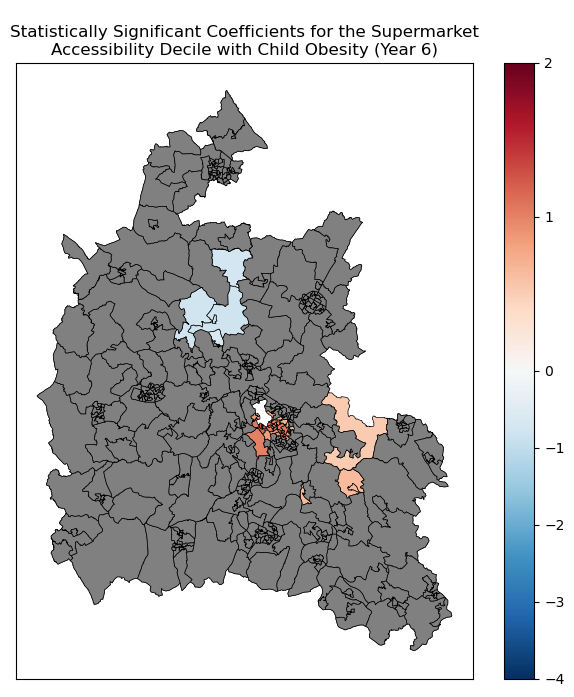

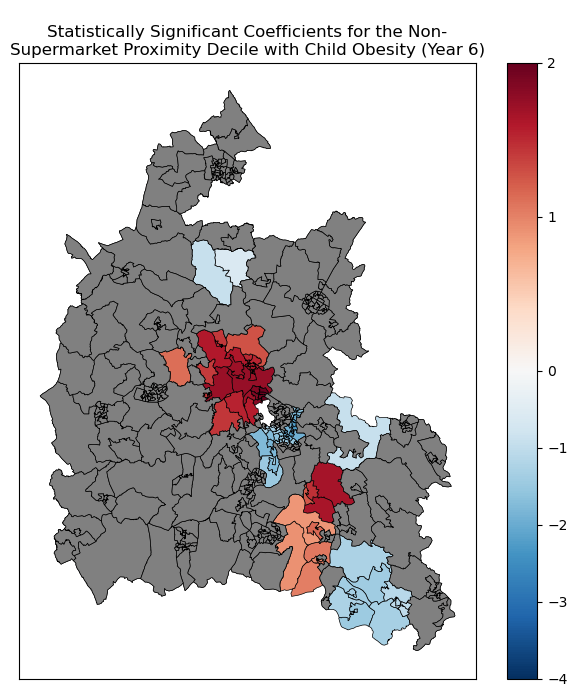

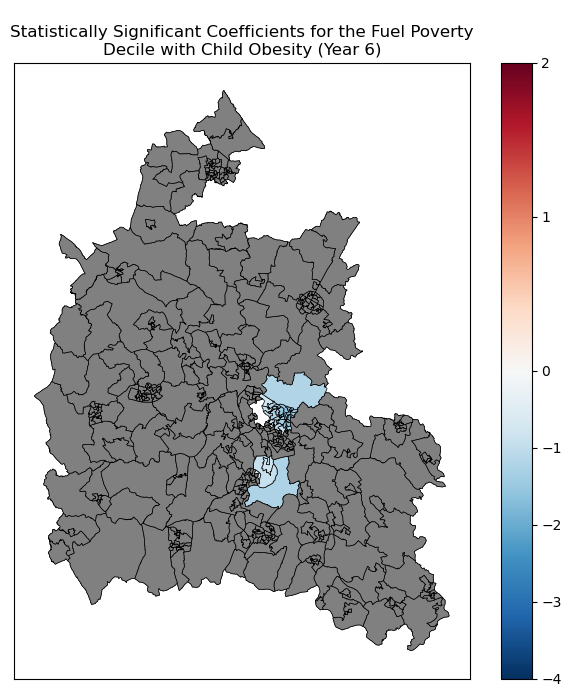

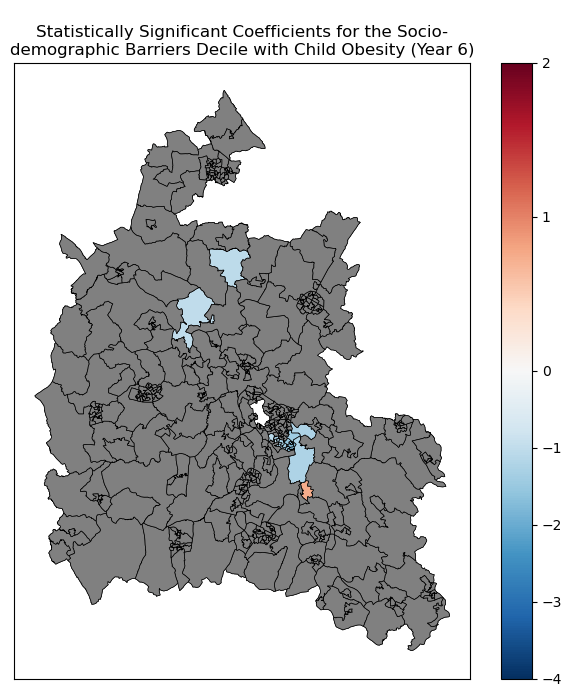

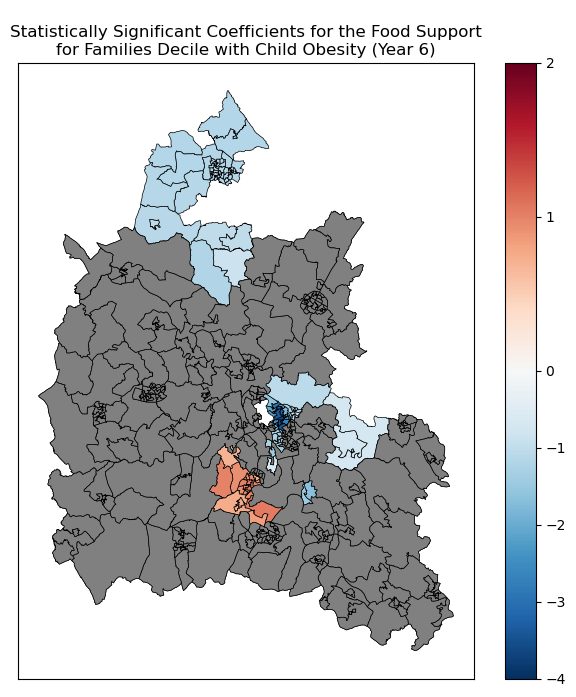

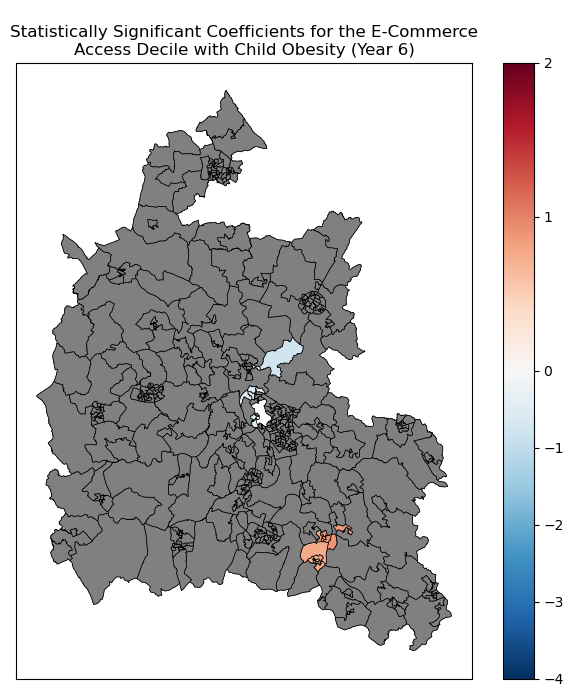

In [217]:
# define a list of column names used to generate the maps
columns_significance = ['Supermarket Proximity','Supermarket Accessibility','Non-Supermarket Proximity',
                        'Fuel Poverty','Socio-demographic Barriers',
                        'Food Support for Families','E-Commerce Access']
# define a list of dimension names to used to set titles for the maps
title_dimensions = ['Supermarket Proximity',
                   'Supermarket Accessibility',
                   'Non-Supermarket Proximity',
                   'Fuel Poverty',
                   'Socio-demographic Barriers',
                    'Food Support for Families',
                   'E-Commerce Access']

# create the maps
for col,title in list(zip(columns_significance,title_dimensions)):
    fig,ax = plt.subplots(figsize=(8,8))
    parameter_estimates.plot(
    col,
    ax=ax,
    legend=True,
    **kwargs,
    cmap=cmap,
    norm=norm
    )
    parameter_estimates[parameter_estimates[col+'_tc'] == 0].plot(ax=ax,
                                                                 color='grey',
                                                                 **kwargs)
    title = f"Statistically Significant Coefficients for the {title} Decile with Child Obesity (Year 6)"
    ax.set_title("\n".join(textwrap.wrap(title,60)))                                                             
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)

In [218]:
# define a list of dimensions names used to capture the parameter estimates
columns_significance = ['Supermarket Proximity','Supermarket Accessibility','Non-Supermarket Proximity',
                        'Fuel Poverty','Socio-demographic Barriers',
                        'Food Support for Families','E-Commerce Access']

# define a list for the sheet names used when exporting the outputs to excel
sheet_names = ['SM_Prox','SM_Acc','NonSM_Prox','FuelPov','SD','FFF','E_Comm']

# define a dictionnary showing the district names and the total LSOAs (2011) count of each to add that 
# to the district summaries
LSOAs_Count = {
    "Cherwell":102,
    "South Oxfordshire":93,
    "West Oxfordshire":68,
    "Vale of White Horse":81,
    "Oxford":85
}

# list of statistical measures
lst = ['Mean','Median','LSOA_Count','Minimum','Maximum']

# create the statistical summary
for col,sheet_name in zip(columns_significance,sheet_names):
    district_estimates = parameter_estimates[parameter_estimates[col+"_tc"] !=0].groupby('District').agg(
        LSOA_Count=('LSOA21CD','nunique'),
        Mean=(col,'mean'),
        Minimum = (col,'min'),
        Median = (col,'median'),
        Maximum = (col,'max'),
    ).reset_index()
    district_estimates['Total_LSOAs'] = district_estimates['District'].map(LSOAs_Count)
    district_estimates['LSOA_Coverage'] = round(district_estimates['LSOA_Count']/district_estimates['Total_LSOAs']*100,2)
    district_estimates[lst] = district_estimates[lst].round(3)
    with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/Datasets/GWR with Child Obesity (Year Six).xlsx",
                   engine="openpyxl", mode="a") as writer:
        district_estimates.to_excel(writer, sheet_name = f"Summary_{sheet_name}")
   

### Get the significant LSOAs list for each District and Dimensions

In [219]:
for col,sheet_name in zip(columns_significance, sheet_names):
    Sig_LSOA_list = parameter_estimates[parameter_estimates[col+"_tc"] != 0].round(3)
    Sig_LSOA_list = Sig_LSOA_list[['LSOA21CD','LSOA21NM','Area','District',col]].merge(Ox_dem[['LSOA21CD','LSOA21NM','RUC11']], 
                                                                             on='LSOA21CD',how='inner').reset_index()
    with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/Datasets/GWR with Child Obesity (Year Six).xlsx",
                   engine="openpyxl", mode="a") as writer:
        Sig_LSOA_list.to_excel(writer, sheet_name = f"Sig_{sheet_name}")

### Group the district-level estimates of LSOAs by the RUC classification

In [220]:
# create a dictionnary of the Cherwell LSOAs count by RUC classification 
District_RUC_LSOA_Count = {
    "Cherwell":{
        "Urban city and town": 69,
        "Rural village and dispersed": 26,
        "Rural town and fringe": 7
    },
    "South Oxfordshire":{
        "Urban city and town": 49,
        "Rural village and dispersed": 21,
        "Rural town and fringe": 23
    },
    "West Oxfordshire":{
        "Urban city and town": 28,
        "Rural village and dispersed": 19,
        "Rural town and fringe": 21
    },
    "Oxford":{
        "Urban city and town": 84,
        "Rural village and dispersed": 0,
        "Rural town and fringe": 1
    },
    "Vale of White Horse":{
        "Urban city and town": 49,
        "Rural village and dispersed": 10,
        "Rural town and fringe": 22
    }
}

# define a function to get the LSOA count values from the dictionnary defined above
def get_value(row):
    return District_RUC_LSOA_Count[row["District"]][row['RUC11']]

# create the dataframe
for col,sheet_name in zip(columns_significance, sheet_names):
    Grouped_RUC = parameter_estimates[parameter_estimates[col+"_tc"] != 0]
    Grouped_RUC = Grouped_RUC[['LSOA21CD','District',col]].merge(Ox_dem[['LSOA21CD',
                                                                         'LSOA21NM','RUC11']], on='LSOA21CD', how='inner')
    Grouped_RUC = Grouped_RUC.groupby(['District','RUC11']).agg(
        LSOA_Count = ('LSOA21CD','nunique'),
        Coeff_Median = (col,'median')
    ).reset_index()
    Grouped_RUC['Total_LSOAs'] = Grouped_RUC.apply(get_value, axis=1)
    Grouped_RUC['Coeff_Median'] = round(Grouped_RUC['Coeff_Median'],3)
    Grouped_RUC['LSOA_Coverage'] = round(Grouped_RUC['LSOA_Count']/Grouped_RUC['Total_LSOAs']*100,2)
    with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/Datasets/GWR with Child Obesity (Year Six).xlsx",
                   engine="openpyxl", mode="a") as writer:
        Grouped_RUC.to_excel(writer, sheet_name = f"Sig_RUC_{sheet_name}")

### Check the GWR Residuals

C:\Users\medaamm\AppData\Local\Temp\ipykernel_16944\2807315889.py:4: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  plt.scatter(ppfi_Ox_Reordered.geometry.centroid.x,
C:\Users\medaamm\AppData\Local\Temp\ipykernel_16944\2807315889.py:5: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  ppfi_Ox_Reordered.geometry.centroid.y,


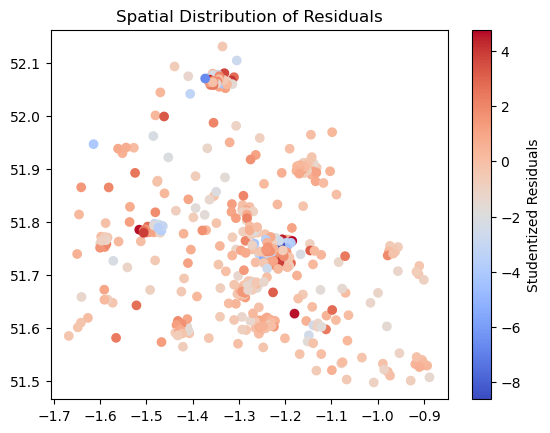

In [221]:
# get the residuals
s_resids = gwr_results.resid_response

plt.scatter(ppfi_Ox_Reordered.geometry.centroid.x, 
            ppfi_Ox_Reordered.geometry.centroid.y, 
            c=s_resids,
            cmap='coolwarm')
plt.colorbar(label='Studentized Residuals')
plt.title('Spatial Distribution of Residuals')
plt.show()

In [222]:
w = Queen.from_dataframe(ppfi_Ox_Reordered)
moran_test = Moran(s_resids, w)
print(f"Moran's I: {moran_test.I:.4f}, p-value: {moran_test.p_sim:.4f}")

C:\Users\medaamm\AppData\Local\Temp\ipykernel_16944\1260155658.py:1: FutureWarning: `use_index` defaults to False but will default to True in future. Set True/False directly to control this behavior and silence this warning
  w = Queen.from_dataframe(ppfi_Ox_Reordered)


Moran's I: 0.1440, p-value: 0.0010


While the p-value associated with Moran's I is significant, the Moran's I value indicates moderate spatial autocorrelation. The Moran's I value from the GWR model is significantly lower than that from the OLS regression.

## Fit a GWR model with the Prevalence of Child Obesity at Y6 as the dependent variable and the PPFI combined decile as the independent variable

### Define the variables

In [223]:
# define the dependent variable as RY obesity levels
y = ppfi_Ox_Reordered['% Obese Children (Year 6)'].values.reshape(-1,1)

# define the independent variables as the dimensions of the PPFI
X = ppfi_Ox_Reordered[['PPFI Combined Decile']].values

y = np.array(y)
X = np.array(X)

### Define the coordinates

In [224]:
u = points.x
v = points.y
coords = list(zip(u,v))

### Calibrate the model and compute the optimal bandwidth

In [225]:
gwr_selector = Sel_BW(coords, y, X, kernel='bisquare')
gwr_bw = gwr_selector.search()
print(gwr_bw)

45.0


### Fit the model

In [226]:
gwr_model = GWR(coords, y, X, bw=gwr_bw, kernel='bisquare')

### Get the results

In [227]:
gwr_results = gwr_model.fit()

### Get the global R-squared value

In [228]:
global_R2 = gwr_results.R2
print(global_R2)

0.7377742628130437


## Model Diagnostics

### View the statistical summary of model results

In [229]:
gwr_results.summary()

Model type                                                         Gaussian
Number of observations:                                                 409
Number of covariates:                                                     2

Global Regression Results
---------------------------------------------------------------------------
Residual sum of squares:                                           6819.361
Log-likelihood:                                                   -1155.769
AIC:                                                               2315.538
AICc:                                                              2317.598
BIC:                                                               4371.779
R2:                                                                   0.163
Adj. R2:                                                              0.161

Variable                              Est.         SE  t(Est/SE)    p-value
------------------------------- ---------- ---------- ------

### Create a statistical summary of the model parameters

In [230]:
parameters_summary = pd.DataFrame()
col_names = ['Intercept', 'Combined Decile']
lst = ['Mean','STD','Min','Median','Max']
parameters_summary['Variable'] = col_names

mean_values = []
sd_values = []
min_values = []
median_values = []
max_values = []

gwr_results_df = pd.DataFrame(gwr_results.params)

for i in range(2):
    mean = gwr_results_df[i].mean()
    mean_values.append(round(mean,3))
    
    std = gwr_results_df[i].std()
    sd_values.append(round(std,3))
    
    minimum = gwr_results_df[i].min()
    min_values.append(round(minimum,3))
    
    maximum = gwr_results_df[i].max()
    max_values.append(round(maximum,3))
    
    median = gwr_results_df[i].median()
    median_values.append(round(median,3))

parameters_summary['Mean'] = mean_values
parameters_summary['STD'] = sd_values
parameters_summary['Min'] = min_values
parameters_summary['Median'] = median_values
parameters_summary['Max'] = max_values

### Export the statistical Summary to an Excel file

In [231]:
with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/Datasets/GWR with Child Obesity (Year Six).xlsx",
                   engine="openpyxl", mode="a") as writer:
    parameters_summary.to_excel(writer, sheet_name = "Model 1 Parameters Summary")

### Visualize the Statistical Significance of Parameter Estimates

In [232]:
# default behaviour using corrected alpha
filter_tc = gwr_results.filter_tvals()

# without correction using common alpha
filter_t = gwr_results.filter_tvals(alpha=0.05)

# create a dataframe for the parameter estimates
parameter_estimates = pd.DataFrame()

# capture the parameter estimates
parameter_estimates['PPFI Combined Decile'] = gwr_results.params[:,1]
parameter_estimates['PPFI Combined Decile_t'] = filter_t[:,1]
parameter_estimates['PPFI Combined Decile_tc'] = filter_tc[:,1]

# add other useful columns 
parameter_estimates[['LSOA21CD','LSOA21NM','Area','geometry','District']] = ppfi_Ox_Reordered[['LSOA21CD','LSOA21NM','Area','geometry','District']]

# convert the merged dataframe to a GeoPandas one
parameter_estimates = gpd.GeoDataFrame(parameter_estimates, geometry='geometry').to_crs('EPSG:3857')

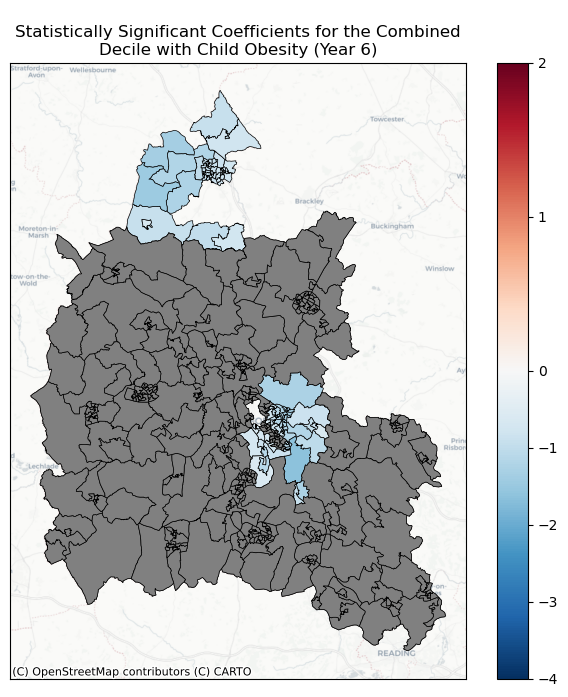

In [233]:
# generate the map of the statistically significant parameter estimates
fig,ax = plt.subplots(figsize=(8,8))

parameter_estimates.plot(
    'PPFI Combined Decile',
    ax=ax,
    legend=True,
    **kwargs,
    cmap=cmap,
    norm=norm
)

parameter_estimates[filter_tc[:,1] == 0].plot(ax=ax,
                                              color='grey',
                                            **kwargs
                                             )
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
title = f"Statistically Significant Coefficients for the Combined Decile with Child Obesity (Year 6)"
ax.set_title("\n".join(textwrap.wrap(title,60)))  
ctx.add_basemap(ax=ax, source=ctx.providers.CartoDB.Positron)

plt.show()

In [234]:
district_estimates = parameter_estimates[filter_tc[:,1] !=0].groupby('District').agg(Mean = ('PPFI Combined Decile','mean'),
                                            Median = ('PPFI Combined Decile','median'),
                                            LSOA_Count = ('LSOA21CD','nunique'),
                                            Minimum = ('PPFI Combined Decile','min'),
                                            Maximum = ('PPFI Combined Decile','max')
                                                               ).reset_index()
lst = ['LSOA_Count','Mean','Median','Minimum','Maximum']
district_estimates[lst] = district_estimates[lst].round(3)
LSOAs_Count = {
    "Cherwell":102,
    "South Oxfordshire":93,
    "West Oxfordshire":68,
    "Vale of White Horse":81,
    "Oxford":85
}
def get_value(row):
    return LSOAs_Count[row]
district_estimates['Total_LSOAs'] = district_estimates['District'].apply(get_value)
district_estimates['LSOA_Coverage'] = round(district_estimates['LSOA_Count']/district_estimates['Total_LSOAs']*100,3)
with pd.ExcelWriter("C:/Users/medaamm/OneDrive - University of Leeds/Project 1 Final Paper/DSDP-Project-1/Datasets/GWR with Child Obesity (Year Six).xlsx",
                   engine="openpyxl", mode="a") as writer:
    district_estimates.to_excel(writer, sheet_name = "Model 1_Sig")

### Checking for Multicollinearity in the model with the dimensions as independent variables

In [235]:
# create a copy of the merged dataframe
ppfi_Ox_Reordered_copy = ppfi_Ox_Reordered.copy()

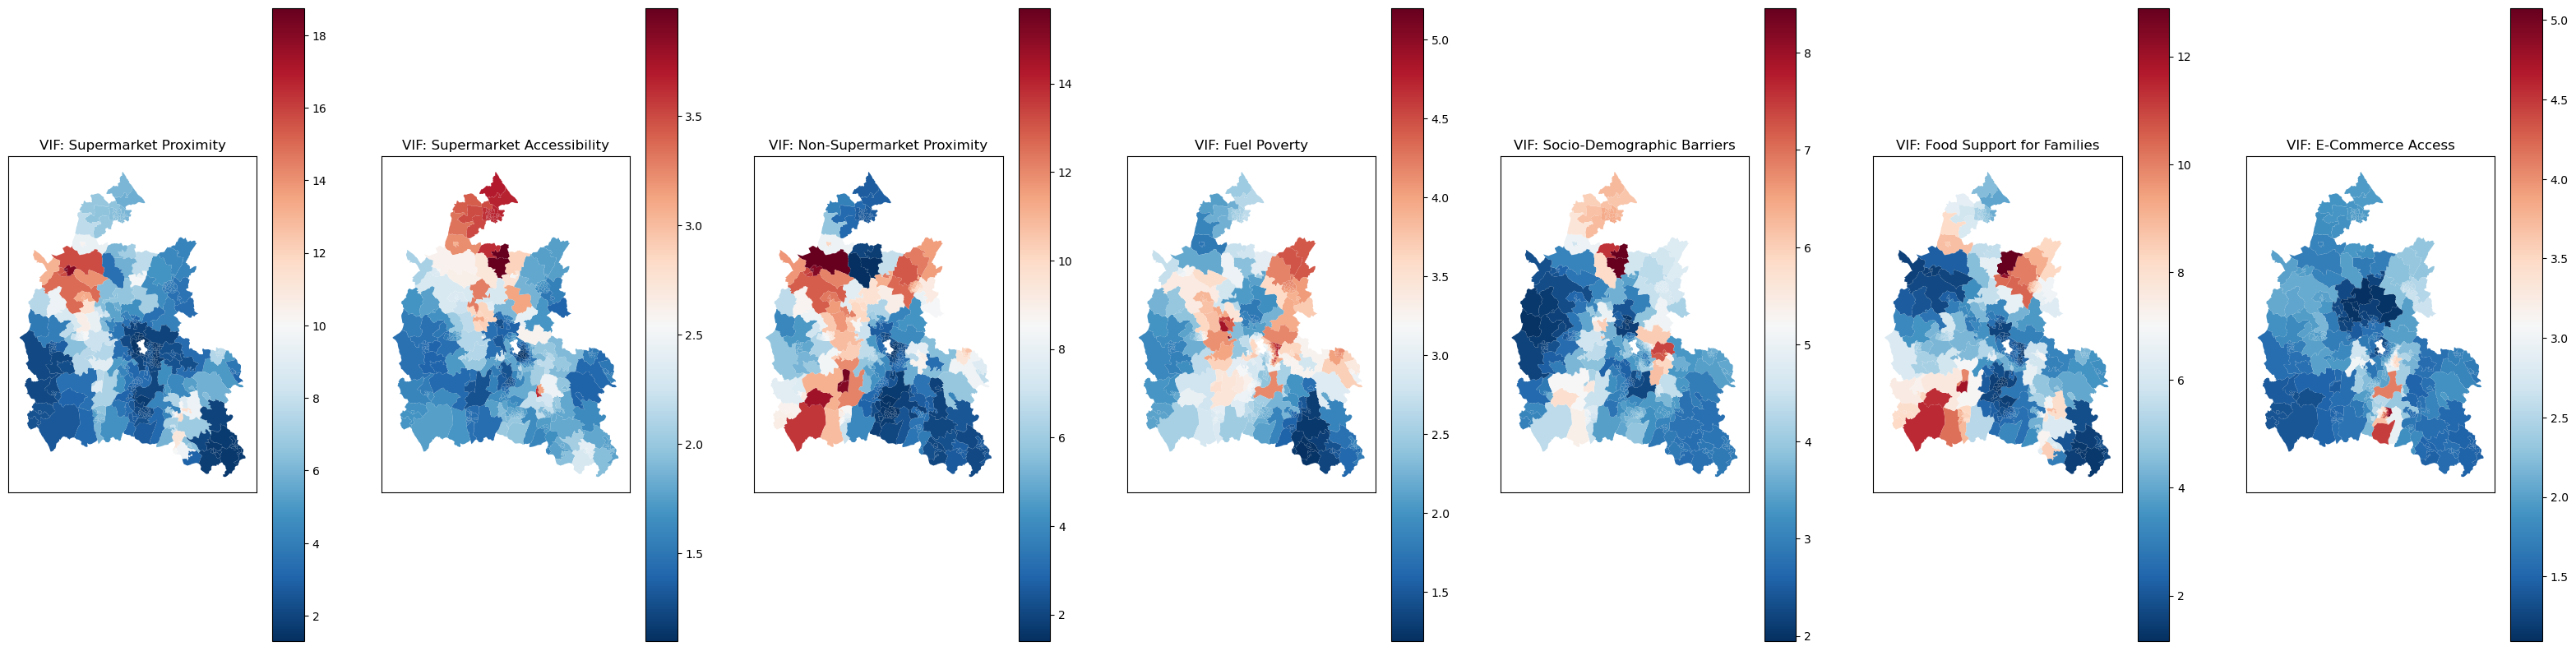

In [239]:
# Correct the data types of all columns
ppfi_Ox_Reordered_copy[cols] = ppfi_Ox_Reordered_copy[cols].apply(pd.to_numeric)

# define the dependent variable as the prevalence of child obesity
y = ppfi_Ox_Reordered_copy['% Obese Children (Year 6)'].values.reshape(-1,1)

# define the independent variables as the dimensions of the PPFI
X = ppfi_Ox_Reordered_copy[cols].values

y = np.array(y)
X = np.array(X)

# Define the u and v coordinates
u = points.x
v = points.y
coords = list(zip(u,v))

# Model calibration
gwr_selector = Sel_BW(coords, y, X, kernel='bisquare')
gwr_bw = gwr_selector.search()

# Fit the model
gwr_model = GWR(coords, y, X, bw=gwr_bw, kernel='bisquare')

# get the results
gwr_results = gwr_model.fit()

# capture the multicollinearity measures
LCC,VIF,CN,VDP = gwr_results.local_collinearity()

# define the names of the independent variables
names = ['Supermarket Proximity',
        'Supermarket Accessibility',
        'Non-Supermarket Proximity',
        'Fuel Poverty',
        'Socio-Demographic Barriers',
        'Food Support for Families',
        'E-Commerce Access']

# create the maps for VIF
fig,ax = plt.subplots(1,7,figsize=(40,10))
for col in range(7):
    ppfi_Ox_Reordered_copy['vif'] = VIF[:, col]
    ppfi_Ox_Reordered_copy.plot('vif', ax=ax[col], legend=True, cmap='RdBu_r')
    ax[col].set_title('VIF: ' + names[col], fontsize=12)
    ax[col].get_xaxis().set_visible(False)
    ax[col].get_yaxis().set_visible(False)